In [1]:
import requests
import pandas as pd
import os
import glob
from datetime import datetime
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
def filter_data_for_modeling(clean_hdb_df, year_cutoff=2013):
    # Ensure month and lease_commence_date are datetime
    df = clean_hdb_df.copy()

    # Drop rows with missing or invalid price
    df = df[df["resale_price"].notnull() & (df["resale_price"] > 0)]

    #date type
    df["month"] = pd.to_datetime(df["month"])
    df["lease_commence_date"] = pd.to_datetime(df["lease_commence_date"], errors='coerce')

    # Features
    feature_df = pd.DataFrame({
        "transaction_id": df["transaction_id"],
        "resale_year": df["month"].dt.year,
        "town": df["town"],
        "flat_type": df["flat_type"],
        "flat_age": ((df["month"] - df["lease_commence_date"]).dt.days / 365.25).clip(lower=0),
    })

    # Targets (log-transform)
    target_df = pd.DataFrame({
        "transaction_id": df["transaction_id"],
        "resale_price": df["resale_price"]
    })

    # Split into past and future
    past_mask = feature_df["resale_year"] <= year_cutoff
    future_mask = feature_df["resale_year"] > year_cutoff

    past_feature_df = feature_df[past_mask].copy()
    future_feature_df = feature_df[future_mask].copy()

    past_target_df = target_df[past_mask].copy()
    future_target_df = target_df[future_mask].copy()

    return past_feature_df, past_target_df, future_feature_df, future_target_df


In [3]:
clean_hdb_df1 = pd.read_csv('Processed_Data/hdb_data_with_coords_mrt_dist_id.csv',
    parse_dates=['month', 'lease_commence_date'])

In [4]:
# copy
df = clean_hdb_df1.copy()

In [6]:
past_feature_df, past_target_df, future_feature_df, future_target_df = filter_data_for_modeling(df, year_cutoff=2013)

Test Train split on past data

In [7]:
from sklearn.model_selection import train_test_split

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    past_feature_df, past_target_df, test_size=0.2, random_state=42
)


# One-hot encode categoricals, scale numerics

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [9]:
def preprocess_features_pipeline(feature_df, numeric_features=None, categorical_features=None, preprocessor=None, fit=True):
    df = feature_df.copy()
    if "transaction_id" in df.columns:
        df = df.drop(columns=["transaction_id"])

    if numeric_features is None:
        numeric_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    if categorical_features is None:
        categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()

    if preprocessor is None:
        preprocessor = ColumnTransformer(transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
        ])

    if fit:
        X_processed = preprocessor.fit_transform(df)
    else:
        X_processed = preprocessor.transform(df)

    return X_processed, preprocessor


In [10]:
categorical_cols = ["town", "flat_type"]
numeric_cols = ["resale_year", "flat_age"]

In [11]:
X_train, preprocessor = preprocess_features_pipeline(X_train_df, numeric_cols, categorical_cols, fit=True)
X_test, _ = preprocess_features_pipeline(X_test_df, numeric_cols, categorical_cols, preprocessor=preprocessor, fit=False)
X_future, _ = preprocess_features_pipeline(future_feature_df, numeric_cols, categorical_cols, preprocessor=preprocessor, fit=False)


# Model

xgboost

In [12]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

In [13]:
# convert df to np array
y_train = y_train_df["resale_price"].values.astype(float)

In [14]:


xgb_model.fit(X_train,y_train)



,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


Model Testing

In [15]:
len(X_test)

138591

## Predicting with Test Data

In [16]:
y_test_predict=xgb_model.predict(X_test)
y_test = y_test_df["resale_price"].values.astype(float)
rmse = np.sqrt(mean_squared_error(y_test, y_test_predict))
mape = np.mean(np.abs((y_test - y_test_predict) / y_test)) * 100
r2 = r2_score(y_test, y_test_predict)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test Mean Absolute Percentage Error: {mape:.2f}%")
print(f"Test R^2 (Coefficient of Determination): {r2:.4f}")

if r2>0.9:
    print("Your predictive model is excellent!!")

Test RMSE: 30568.96
Test Mean Absolute Percentage Error: 9.67%
Test R^2 (Coefficient of Determination): 0.9463
Your predictive model is excellent!!


In [17]:
y_test_predict

array([298193.7 , 363236.97, 127411.91, ..., 132500.6 , 266066.75,
       280607.9 ], shape=(138591,), dtype=float32)

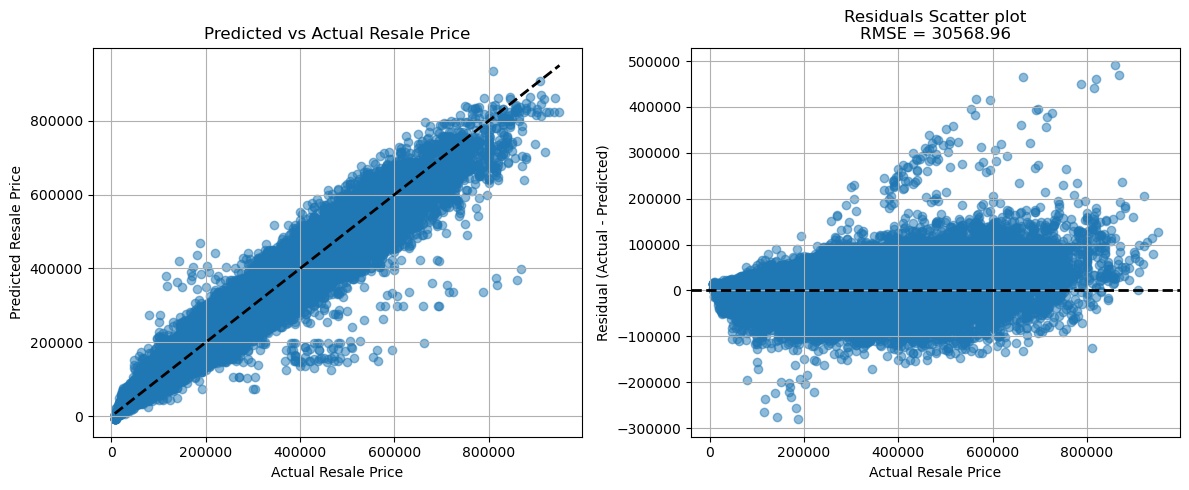

In [18]:
# Scatter plot: predicted vs actual resale prices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_predict, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.title('Predicted vs Actual Resale Price')
plt.grid(True)

# RMSE as residual scatter plot
residuals = y_test - y_test_predict
rmse_values = rmse # Just absolute residuals (RMSE scalar but per-point residual = abs error)
#mape_values = np.abs((y_test - y_test_predict) / y_test) * 100

plt.subplot(1, 2, 2)
plt.scatter(y_test, residuals, alpha=0.5, label='Residuals')
plt.axhline(0, color='k', lw=2, linestyle='--')
plt.xlabel('Actual Resale Price')
plt.ylabel('Residual (Actual - Predicted)')
#plt.ylabel('Percentage Residual (Actual - Predicted)')
plt.title(f'Residuals Scatter plot\nRMSE = {rmse:.2f}')
plt.grid(True)

plt.tight_layout()
plt.show()




## Predicting with new data

In [19]:
example_df = pd.DataFrame([{ "transaction_id":0,"flat_age": 25, "flat_type": "4 ROOM", "town": "BEDOK", "resale_year": 2014 }])


In [20]:
example_df

,transaction_id,flat_age,flat_type,town,resale_year
0,0,25,4 ROOM,BEDOK,2014


In [21]:
X_example, _ = preprocess_features_pipeline(
    example_df,
    numeric_features=numeric_cols,
    categorical_features=categorical_cols,
    preprocessor=preprocessor,  # preprocessor fitted during training
    fit=False   
)

In [22]:
pred_price = xgb_model.predict(X_example)
print(f"Predicted resale price for example flat: SGD {pred_price}")

Predicted resale price for example flat: SGD [441047.94]


In [23]:
def predict_resale_price(model, actual_df, flat_type, town, flat_age, resale_year=2014):
    """
    Predict resale price for a specific flat
    
    Parameters:
    -----------
    model_results : statsmodels results object
    training_columns : list of column names from training
    flat_type : str, e.g., '3 ROOM', '4 ROOM', '5 ROOM'
    town : str, e.g., 'ANG MO KIO', 'BEDOK'
    flat_age : float, age of flat in years
    resale_year : int, year of resale
    
    Returns:
    --------
    predicted_price : float
    """
    
    # Create input dataframe
    input_df = pd.DataFrame({
            'transaction_id': [0],  # Dummy ID
            'resale_year': [resale_year],
            'town': [town],
            'flat_age': [flat_age],
            'flat_type': [flat_type]
            })
    print(input_df.shape)
    
    X_input, _ = preprocess_features_pipeline(input_df,
            numeric_features=numeric_cols,
            categorical_features=categorical_cols,
            preprocessor=preprocessor,  # preprocessor fitted during training
            fit=False   
            )
  
    predicted_price = model.predict(X_input)

    # Find similar flats in actual data
    similar_flats = actual_df[
        (actual_df['flat_type'] == flat_type.upper()) &
        (actual_df['town'] == town.upper()) &
        (actual_df['flat_age'] >= flat_age - 2) &
        (actual_df['flat_age'] <= flat_age + 2) &
        (actual_df['resale_year'] == resale_year)
        #(actual_df['resale_year'] >= resale_year - 1) &
        #(actual_df['resale_year'] <= resale_year + 1)
    ]
    
    if len(similar_flats) > 0:
        print(f"\nSimilar Flats Found: {len(similar_flats)}")
        print(f"  Average Actual Price: ${similar_flats['resale_price'].mean():,.2f}")
        print(f"  Price Range: ${similar_flats['resale_price'].min():,.2f} - ${similar_flats['resale_price'].max():,.2f}")
        print(f"  Median: ${similar_flats['resale_price'].median():,.2f}")
    else:
        print("\nNo similar flats found in dataset")
    

    return predicted_price, similar_flats




In [24]:
predicted_price, similar_flats = predict_resale_price(
    model=xgb_model,
    flat_type='4 ROOM',
    town='BEDOK',
    flat_age=25,
    resale_year=2014,
    actual_df=pd.merge(future_feature_df, future_target_df, on='transaction_id', how='inner')
)

print(f"\nPredicted Resale Price: {predicted_price[0]:.2f}")

(1, 5)

Similar Flats Found: 4
  Average Actual Price: $452,472.00
  Price Range: $400,000.00 - $598,000.00
  Median: $405,944.00

Predicted Resale Price: 441047.94


# Future Data

In [25]:
y_future_predict=xgb_model.predict(X_future)

y_future_true = future_target_df["resale_price"].values.astype(float)

future_rmse = np.sqrt(mean_squared_error(y_future_true, y_future_predict))
future_mape = np.mean(np.abs((y_future_true - y_future_predict) / y_future_true)) * 100
future_r2 = r2_score(y_future_true, y_future_predict)

print(f"Test RMSE: {future_rmse:.2f}")
print(f"Test Mean Absolute Percentage Error: {future_mape:.2f}%")
print(f"Test R^2 (Coefficient of Determination): {future_r2:.4f}")

if future_r2>0.9:
    print("Your predictive model is excellent!!")

Test RMSE: 114031.92
Test Mean Absolute Percentage Error: 16.83%
Test R^2 (Coefficient of Determination): 0.5926


In [30]:
# Ensure all inputs have the same length
assert len(future_feature_df) == len(future_target_df)  == len(y_future_predict), \
    "All inputs must have the same number of rows"

# Combine the two DataFrames side by side
#final_future_df = pd.concat([future_feature_df.reset_index(drop=True),
#                      future_target_df.reset_index(drop=True)], axis=1)
# Merge the two DataFrames on 'transaction_id'
final_future_df = pd.merge(
    future_feature_df,
    future_target_df,
    on='transaction_id',
    how='inner'   # use 'left', 'right', or 'outer' if needed
)

# Display the combined DataFrame
print(final_future_df.head())


# Add y_test and y_test_predict as new columns
#final_future_df['y_test'] = y_test
final_future_df['y_future_predict'] = y_future_predict

# Display the combined DataFrame
print(final_future_df.head())


   transaction_id  resale_year        town flat_type   flat_age  resale_price
0               1         2017  ANG MO KIO    2 ROOM  38.001369      232000.0
1               2         2017  ANG MO KIO    3 ROOM  39.000684      250000.0
2               3         2017  ANG MO KIO    3 ROOM  37.002053      262000.0
3               4         2017  ANG MO KIO    3 ROOM  37.002053      265000.0
4               5         2017  ANG MO KIO    3 ROOM  37.002053      265000.0
   transaction_id  resale_year        town flat_type   flat_age  resale_price  \
0               1         2017  ANG MO KIO    2 ROOM  38.001369      232000.0   
1               2         2017  ANG MO KIO    3 ROOM  39.000684      250000.0   
2               3         2017  ANG MO KIO    3 ROOM  37.002053      262000.0   
3               4         2017  ANG MO KIO    3 ROOM  37.002053      265000.0   
4               5         2017  ANG MO KIO    3 ROOM  37.002053      265000.0   

   y_future_predict  
0        290817.250  
1

In [29]:
final_future_df.columns

Index(['transaction_id', 'resale_year', 'town', 'flat_type', 'flat_age',
       'transaction_id', 'resale_price', 'y_future_predict'],
      dtype='object')

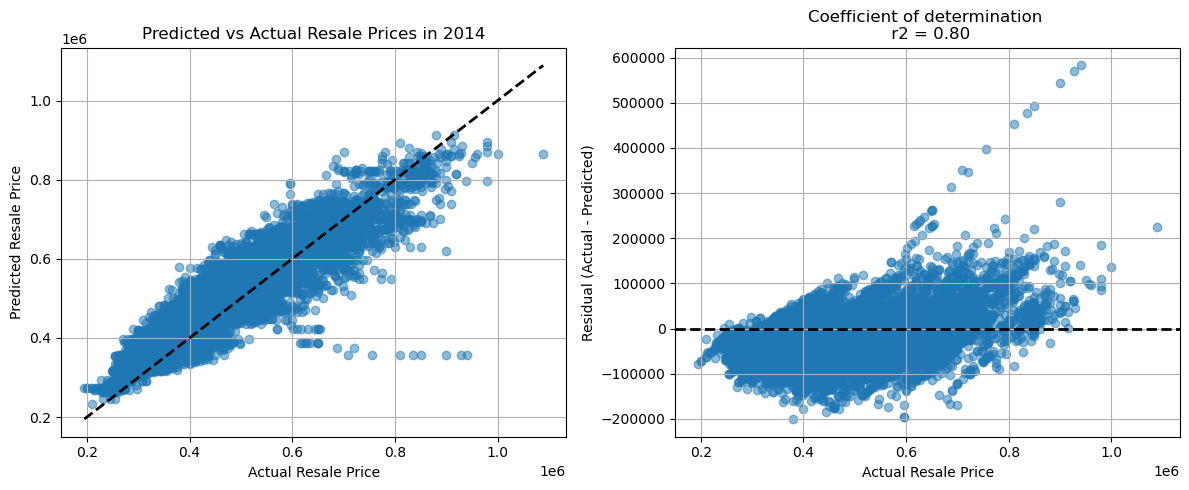

In [41]:
# Scatter plot: predicted vs actual resale prices

future_df_2014= final_future_df[final_future_df['resale_year']==2014]
y_future_true= future_df_2014['resale_price'].values.astype(float)
y_future_predict= future_df_2014['y_future_predict'].values.astype(float)

plt.figure(figsize=(12, 5))

# --- Predicted vs Actual ---
plt.subplot(1, 2, 1)
plt.scatter(y_future_true, y_future_predict, alpha=0.5)
plt.plot([y_future_true.min(), y_future_true.max()],
         [y_future_true.min(), y_future_true.max()], 'k--', lw=2)
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.title('Predicted vs Actual Resale Prices in 2014')
plt.grid(True)

# --- Residuals ---
residuals = y_future_true - y_future_predict
rmse_values = rmse  # RMSE scalar; per-point residual = absolute error
# mape_values = np.abs((y_future_true - y_future_predict) / y_future_true) * 100
future_r2 = r2_score(y_future_true, y_future_predict)

plt.subplot(1, 2, 2)
plt.scatter(y_future_true, residuals, alpha=0.5, label='Residuals')
plt.axhline(0, color='k', lw=2, linestyle='--')
plt.xlabel('Actual Resale Price')
plt.ylabel('Residual (Actual - Predicted)')
# plt.ylabel('Percentage Residual (Actual - Predicted)')
#plt.title(f'Residuals Scatter Plot\nRMSE = {rmse:.2f}')
plt.title(f'Coefficient of determination \n r2 = {future_r2:.2f}')

plt.grid(True)

plt.tight_layout()
plt.show()


In [38]:
future_df_2014

,transaction_id,resale_year,town,flat_type,flat_age,resale_price,y_future_predict
216743,252851,2014,ANG MO KIO,2 ROOM,34.001369,280000.0,289905.40625
216744,252852,2014,ANG MO KIO,3 ROOM,34.001369,290000.0,378477.25000
216745,252853,2014,ANG MO KIO,3 ROOM,35.000684,300000.0,381009.50000
216746,252854,2014,ANG MO KIO,3 ROOM,34.001369,315000.0,378477.25000
216747,252855,2014,ANG MO KIO,3 ROOM,34.001369,318000.0,378477.25000
...,...,...,...,...,...,...,...
232834,268942,2014,YISHUN,5 ROOM,26.915811,580000.0,518178.53125
232835,268943,2014,YISHUN,EXECUTIVE,26.915811,540000.0,633595.75000
232836,268944,2014,YISHUN,EXECUTIVE,22.915811,738000.0,632597.56250
232837,268945,2014,YISHUN,EXECUTIVE,29.913758,592000.0,662369.43750
